In [178]:
# Initial Imports 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
pd.set_option("display.max_columns", None)

In [330]:
df_client_data = pd.read_csv('../HET/Data/client_data.csv')
df_client_membership = pd.read_csv('../HET/Data/client_membership.csv')
df_benchmark = pd.read_csv('../HET/Data/benchmark_data.csv')

/var/folders/h4/bmfyh9q95ws8cxksqm1z9m4c0000gn/T/ipykernel_21049/1195080869.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_client_data = pd.read_csv('../HET/Data/client_data.csv')
/var/folders/h4/bmfyh9q95ws8cxksqm1z9m4c0000gn/T/ipykernel_21049/1195080869.py:3: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_benchmark = pd.read_csv('../HET/Data/benchmark_data.csv')


# Paid PMPM 
Paid per Member per Month - is a primary metric used to evaluate performance.

Calculated as = (Total_Paid / Member_Months)

We'll train an ML regressor model to predict PMPM and,  
use feature importance to gain insight on which features most contribute to PMPM


## Initial Data Manipulation 

In [321]:
df_client_data.dtypes

dw_mbr_key                    object
mbr_months_ccs               float64
Primary_CCS_Dx_Level_1        object
Primary_CCS_Dx_Level_2        object
Total_Allowed                 object
Total_Paid                    object
Allowed_Inpatient             object
Allowed_Outpatient            object
Allowed_Professional          object
Paid_Inpatient                object
Paid_Outpatient               object
Paid_Professional             object
Adm_cnt_Inpatient              int64
Day_cnt_Inpatient              int64
Visit_cnt_Outpatient           int64
Visit_cnt_Professional         int64
Proc_cnt_Professional         object
Svc_unit_cnt_Professional     object
non_utilizer                   int64
dtype: object

In [322]:
# Convert to to numerics, excluding member key and CCS_Dx_levels

object_cols = df_client_data.columns[df_client_data.dtypes.eq('object')]
object_cols
object_cols = object_cols.drop(['dw_mbr_key', 'Primary_CCS_Dx_Level_1', 'Primary_CCS_Dx_Level_2'])

df_client_data[object_cols] = df_client_data[object_cols].apply(pd.to_numeric, errors='coerce')


In [182]:
# Sum Total_Paid for all claims by member 
totals = df_client_data.groupby('dw_mbr_key', as_index=False)['Total_Paid'].sum()

# Merge Totals to client_membership
df = pd.merge(df_client_membership, totals, on='dw_mbr_key')
df.head()

,dw_mbr_key,gender,age,zip_cd,relationship,enrollment_month,MSA,state,area_id,risk_score,sdoh_percentile,urban_percentile,hypertension_ind,depression_ind,hyperlipidemia_ind,cad_ind,diabetes_ind,alcohol_ind,sud_ind,copd_ind,psychotic_ind,hypothyroidism_ind,anxiety_ind,cancer_ind,pregnancy_ind,annual_wellness_visit,Total_Paid
0,"5,960,230,933",F,54,98503,Subscriber,12,"Olympia, WA",WA,"5,301",0.58,0.65,0.82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,295.39
1,"1,400,067,594",M,51,75474,Subscriber,12,"Dallas-Fort Worth-Arlington, TX",TX,"4,807",0.78,0.91,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,1,202.38
2,"165,580,000,688",F,39,75214,Subscriber,12,"Dallas-Fort Worth-Arlington, TX",TX,"4,807",5.65,0.69,0.82,1,1,1,0,1,0,0,0,0,0,1,1,0,0,4239.04
3,"1,450,054,588",F,55,30024,Spouse,12,"Atlanta-Sandy Springs-Marietta, GA",GA,"1,303",0.41,0.41,0.82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00
4,"211,030,034,623",M,10,61704,Dependent,12,"Bloomington-Normal, IL",IL,"1,707",0.21,0.35,0.8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,184.53


In [183]:
# Check merged head() 
totals.loc[totals.dw_mbr_key.isin(['5,960,230,933', '1,400,067,594', '165,580,000,688', '1,450,054,588', '211,030,034,623'])]

,dw_mbr_key,Total_Paid
2566,"1,400,067,594",202.38
13790,"1,450,054,588",0.00
42969,"165,580,000,688",4239.04
61157,"211,030,034,623",184.53
68582,"5,960,230,933",295.39


In [184]:
# Dropping zip_cd, relationship, MSA, state
df = df.drop(['zip_cd', 'relationship', 'MSA', 'state'], axis=1)

# Cast sdoh_percentile, urban_percentile as numerics 
object_cols = df.columns[df.dtypes.eq('object')]
object_cols
object_cols = object_cols.drop(['dw_mbr_key', 'gender', 'area_id'])

df[object_cols] = df[object_cols].apply(pd.to_numeric, errors='coerce')

In [185]:
# Ordinal Encoding Gender and Area ID 
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
df[['gender', 'area_id']] = encoder.fit_transform(df[['gender', 'area_id']])

In [186]:
# Search for nuls in dataframe 
print(df.shape)

# Number of Missing Values in each column 
missing_val_count = (df.isnull().sum())
print(missing_val_count[missing_val_count > 0])

(89966, 23)
sdoh_percentile     1218
urban_percentile    1218
dtype: int64


In [187]:
# Null values account for approximately < 1% of our data.
# We can drop them from our dataframe 

df = df.dropna()

## PMPM Evaluation 

In [188]:
# Calculate PMPM and append to dataframe 
df['PMPM'] = df['Total_Paid'] / df['enrollment_month']

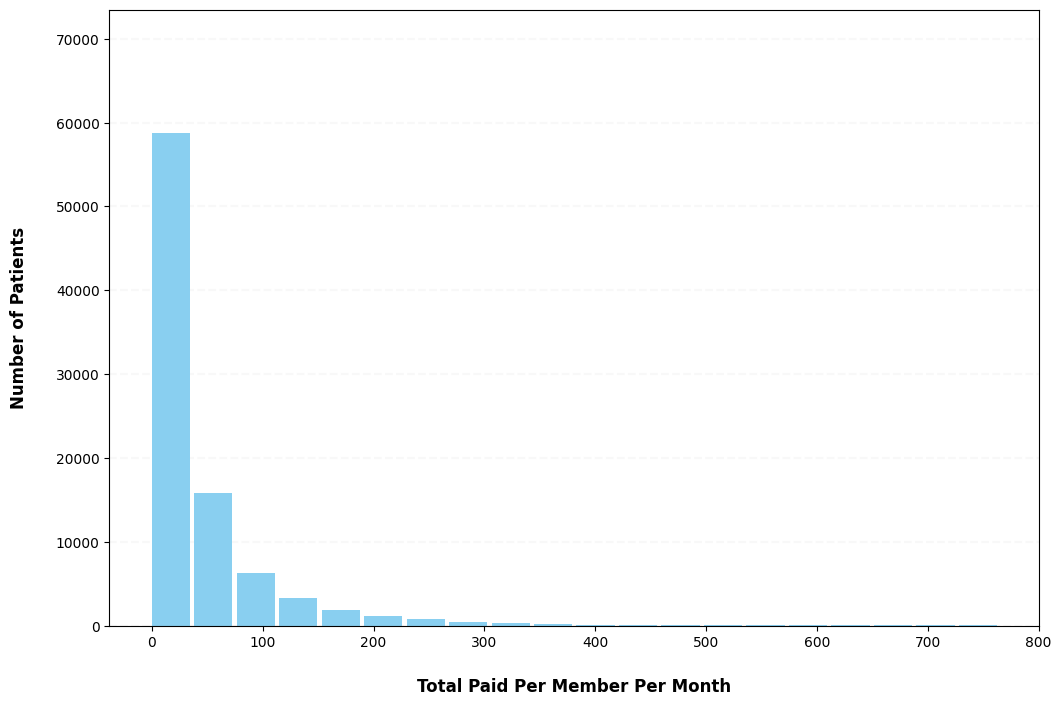

In [189]:
ax = df.hist(column='PMPM', bins=20, grid=False, figsize=(12,8), color='#89cff0', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:
    
    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Total Paid Per Member Per Month", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Number of Patients", labelpad=20, weight='bold', size=12)

## ML Modeling

### Data Split 

In [241]:
# Get X y variables 
# X = df.drop(['enrollment_month','Total_Paid', 'PMPM'], axis=1)
X = df.drop(['enrollment_month','Total_Paid', 'PMPM', 'risk_score'], axis=1)
y = df.PMPM

# Data split 
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.7, test_size=.3, random_state=0)

# Drop unique member ID for ML modeling 
X_train_ml = X_train.drop(['dw_mbr_key'], axis=1)
X_val_ml = X_val.drop(['dw_mbr_key'], axis=1)

### Training Random Forest Regressor

In [242]:
from sklearn.ensemble import RandomForestRegressor

# Define models 
model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)

rf_models = [model_1, model_2, model_3]

In [243]:
# Evaluating models Mean Absolute Error 

from sklearn.metrics import mean_absolute_error

# Function for comparing models 
def score_model(model, X_t=X_train_ml, X_v=X_val_ml, y_t=y_train, y_v=y_val):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

for i in range(len(rf_models)):
    mae = score_model(rf_models[i])
    print("Model %d MAE: %d" % (i+1, mae))

Model 1 MAE: 33
Model 2 MAE: 32
Model 3 MAE: 31


### Use respective RF model to analyze feature importance 

In [244]:
predictions = model_3.predict(X_val_ml)

In [245]:
# Generating predicted dataset 
predicted_dataset = X_val.copy()

predicted_dataset['Actual PMPM'] = y_val
predicted_dataset['Predicted PMPM'] = predictions

predicted_dataset = predicted_dataset[['dw_mbr_key', 'Actual PMPM', 'Predicted PMPM']]
predicted_dataset

#TODO Add Total and Member months to predicted 

,dw_mbr_key,Actual PMPM,Predicted PMPM
58773,"10,330,177,586",35.115000,37.737583
42060,"1,400,129,334",13.744167,55.241440
84129,"1,400,124,172",105.373333,74.122955
88609,"140,400,007,947",51.481667,35.954896
20939,"89,410,002,242",9.574167,38.723038
...,...,...,...
74356,"1,400,126,256",148.940833,67.091006
87246,"1,400,125,354",4.140000,43.884530
83523,"202,220,000,609",35.488333,62.542311
63339,"116,540,006,057",13.720000,37.921723


<BarContainer object of 19 artists>

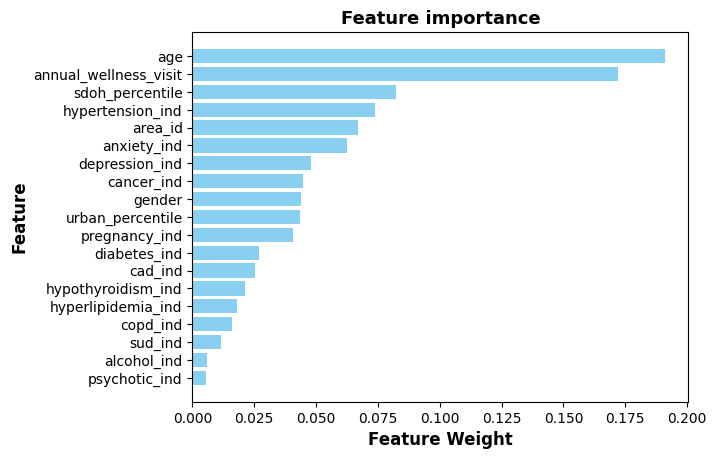

In [246]:
# Get Feature importance 
importances = model_3.feature_importances_
features = X_val_ml.columns


unsorted_list = [(importance, feature) for feature, importance in 
                  zip(features, importances)]
sorted_list = sorted(unsorted_list)

features_sorted = []
importance_sorted = []

for i in sorted_list:
    features_sorted += [i[1]]
    importance_sorted += [i[0]]

# Plot Feature Importance 
plt.title("Feature importance", fontsize=13, fontweight='bold')
plt.xlabel("Feature Weight", fontsize=12, fontweight='bold')
plt.ylabel("Feature", fontsize=12, fontweight='bold')

plt.barh(features_sorted,importance_sorted, color="#89cff0")

# plt.savefig('importance_barh.png', dpi=100)

# Annual Wellness Visit 
From the RF Regressor model, we can see that Age and Annual_Wellness_Visits are have the highest contribution to a high PMPM. 

Inpatient visits are typically more constly. 

We'll now look at the different reasons patients went for an inpatient treatment 



In [403]:
inpatient_df = pd.read_csv('../HET/Data/inpatient.csv')
inpatient_df = inpatient_df.loc[inpatient_df.Paid_Inpatient > 0]


/var/folders/h4/bmfyh9q95ws8cxksqm1z9m4c0000gn/T/ipykernel_21049/637889279.py:1: DtypeWarning: Columns (0,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  inpatient_df = pd.read_csv('../HET/Data/inpatient.csv')


In [404]:
# Total Paid_Inpatient per Primary_CCS_Dx_Level_1
inpatient_totals = inpatient_df.groupby('Primary_CCS_Dx_Level_1', as_index=False)['Paid_Inpatient'].sum()


# Total Inpatient Visits per Primary_CCS_Dx_Level_1
visits = inpatient_df.Primary_CCS_Dx_Level_1.value_counts().rename_axis('Primary_CCS_Dx_Level_1').reset_index(name='counts')

In [405]:
inpatient_df = pd.merge(inpatient_totals, visits, on='Primary_CCS_Dx_Level_1')
inpatient_df

,Primary_CCS_Dx_Level_1,Paid_Inpatient,counts
0,?,16418.08,2
1,Certain conditions originating in the perinata...,262049.17,82
2,Complications of pregnancy; childbirth; and th...,6546032.35,799
3,Congenital anomalies,1314780.34,17
4,Diseases of the blood and blood-forming organs,570884.82,26
5,Diseases of the circulatory system,9105347.03,259
6,Diseases of the digestive system,6587604.07,290
7,Diseases of the genitourinary system,3225958.76,120
8,Diseases of the musculoskeletal system and con...,12845607.20,316
9,Diseases of the nervous system and sense organs,1968218.72,92


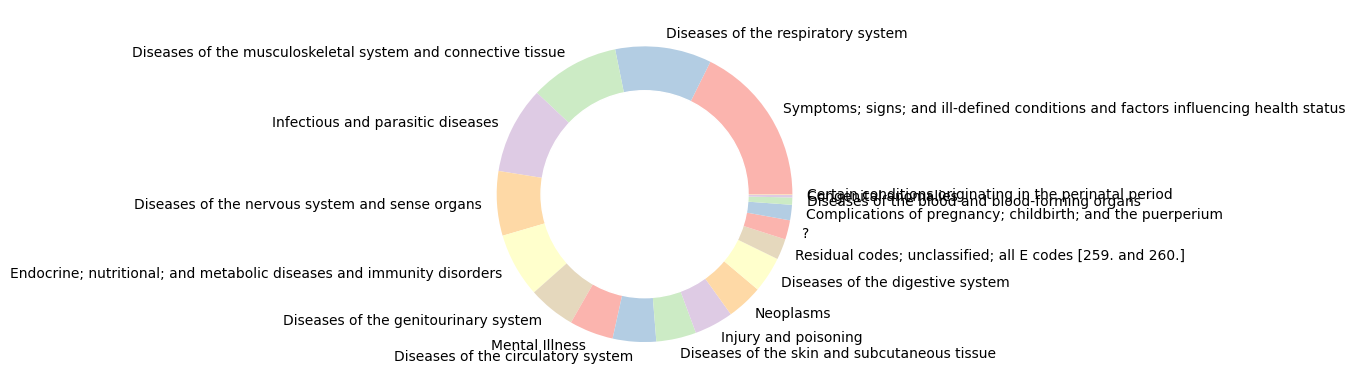

In [270]:
# library
import matplotlib.pyplot as plt
from palettable.colorbrewer.qualitative import Pastel1_7
 
# create data
names = visits.unique_values
size = visits.counts
 
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

from palettable.colorbrewer.qualitative import Pastel1_7
plt.pie(size, labels=names, colors=Pastel1_7.hex_colors)
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

/var/folders/h4/bmfyh9q95ws8cxksqm1z9m4c0000gn/T/ipykernel_21049/3953856108.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


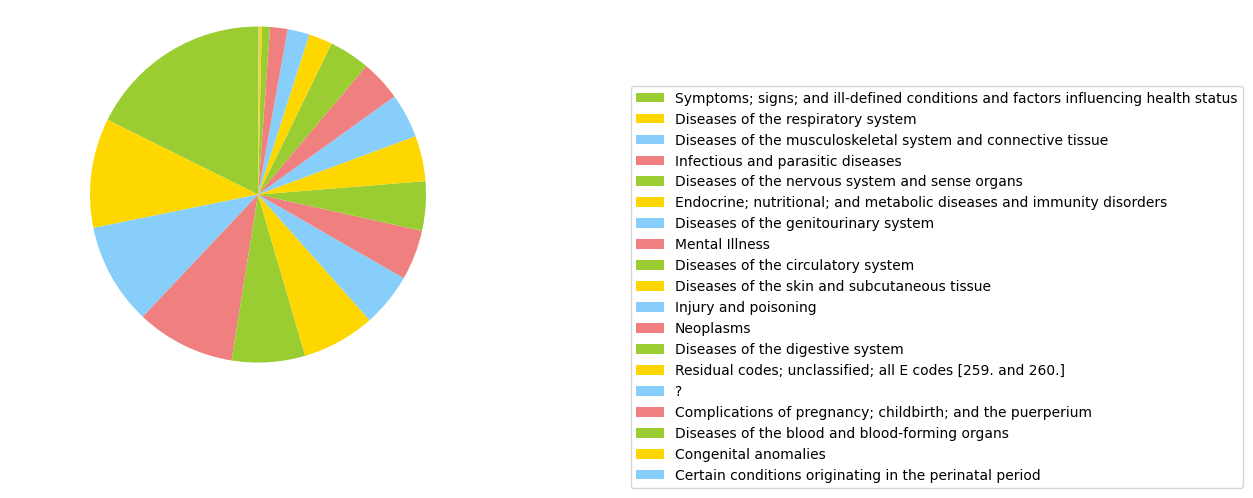

In [287]:
import matplotlib.pyplot as plt

labels = visits.unique_values
sizes = visits.counts


colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
patches, texts = plt.pie(sizes, colors=colors, startangle=90)

plt.legend(patches, labels, loc='right', bbox_to_anchor=((2, 0., 0.5, 0.5)))


plt.axis('equal')
plt.tight_layout()
plt.show()